In [485]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met, u_statistics, u_plot
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pandas as pd
import pickle as pkl
from utils import constants as cnst
from utils import u_plot as uplot
import numpy.ma as ma
from scipy.stats import gaussian_kde, linregress
import scipy.stats as stats

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [486]:
cd ..

/home/ck/pythonWorkspace


In [792]:
msgopen = pd.read_csv('/home/ck/DIR/cornkle/figs/LSTA/corrected_LSTA/new/ERA5/core_txt/cores_gt15000km2_table_AMSRE_LSTA_tracking_new_2hOverlap_17.csv', na_values=-999)

##  Wet / Dry case comparison

Wet: Day 0 / Day -1 > + 0.01% SM anomaly mean (more like 'neutral & wet condition')

Dry: Day  0 < -3% , Day-1 < -1.5% SM anomaly mean

Identified in box + - 90 km and 200km upstream from core centre

In [793]:
msgopen.shape

(19454, 24)

In [794]:
print('Number of ALL cases:', msgopen.shape[0])

Number of ALL cases: 19454


In [806]:
#dry = msgopen[(msgopen['SMmean0']<-3)& (msgopen['SMmean-1'] <-1.5) &(msgopen['SMmean0']>-900)& (msgopen['SMmean-1'] >-900) ]
msgopen = msgopen[(msgopen['lat']>9) & (msgopen['lat']<19) & (msgopen['topo']<450)]
dry = msgopen[(msgopen['dtime'] <= 2) & (msgopen['SMmean0'] < -1.5) & (msgopen['SMmean-1'] < -4.3) & (msgopen['LSTAslotfrac'] >= 0.05)]

In [807]:
wet = msgopen[(msgopen['dtime'] <= 2) & (msgopen['SMmean0']>0.01) & (msgopen['SMmean-1']>0.8) & (msgopen['LSTAslotfrac'] >= 0.05) ]#msgopen[(msgopen['SMmean0']>0.01)& (msgopen['SMmean-1'] >0.01)]

In [808]:
print(len(dry))
print(len(wet))

286
283


In [809]:
len(msgopen[msgopen['t']<=-60])

14381

In [810]:
len(msgopen[msgopen['ERAqmean']>14.8]) / len(msgopen)

0.5443988596064251

In [811]:
mask = msgopen[np.isfinite(msgopen['SMmean0'])  & np.isfinite(msgopen['ERAqmean']) & np.isfinite(msgopen['t'])]             

In [812]:
mask.keys()

Index(['id', 'year', 'month', 'day', 'hour', 'lon', 'lat', 'xloc', 'yloc',
       'area', 'csize', 't', 'storm_id', 'topo', 'SMmean0', 'SMdry0', 'SMwet0',
       'SMmean-1', 'SMdry-1', 'SMwet-1', 'LSTAmean', 'LSTAslotfrac', 'dtime',
       'ERAqmean'],
      dtype='object')

In [813]:
len(mask[mask['ERAqmean']>14.8]) / len(mask)

0.7215416379903647

In [814]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    rr = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, rr

pears (-0.043417252051087485, 0.00021409486511742614)


Text(0,0.5,'SM day0 (%)')

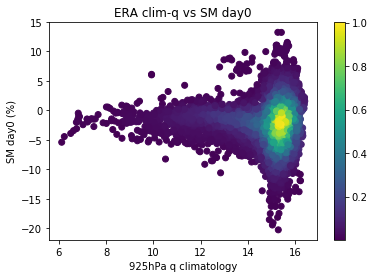

In [815]:
plt.figure()
data1, r1 = density_plot(mask['ERAqmean'], mask['SMmean0'])
mappable=plt.scatter(mask['ERAqmean'], mask['SMmean0'], c=data1)
plt.colorbar(mappable)
plt.axhline(0, xmin=6, xmax=16, color='k')
plt.title('ERA clim-q vs SM day0')
plt.xlabel('925hPa q climatology')
plt.ylabel('SM day0 (%)')

pears (-0.07402618985636171, 2.663402105273971e-10)


(-95, -50)

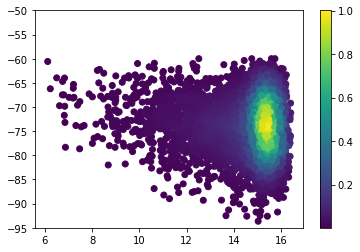

In [816]:
plt.figure()
data1, r1 = density_plot((mask['ERAqmean']), (mask['t']))
mappable = plt.scatter((mask['ERAqmean']), (mask['t']), c=data1)
plt.colorbar(mappable)
plt.axhline(0, xmin=6, xmax=16, color='k')
plt.ylim(-95,-50)

pears (0.0857910755369807, 2.3952624399356944e-13)


(-95, -50)

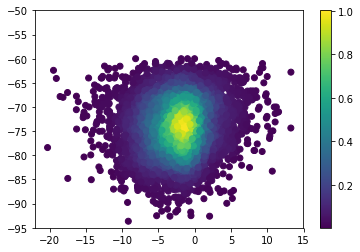

In [817]:
plt.figure()
data1, r1 = density_plot((mask['SMmean0']), (mask['t']))
mappable = plt.scatter((mask['SMmean0']), (mask['t']), c=data1)
plt.colorbar(mappable)
plt.axhline(0, xmin=6, xmax=16, color='k')
plt.ylim(-95,-50)

In [818]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    var = 'SMmean-1'

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    for isq, qql in enumerate(ybins[0:-1]):

        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds[var] >= shl) & (ds[var] < xbins[issh+1]) & (ds.ERAqmean>=qql) & (ds.ERAqmean < ybins[isq+1])
          
            try:
                ds_mmean = np.nansum(ds.t[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
                ds_val = np.sum(np.isfinite(ds.t[poss_ds]))
                #ipdb.set_trace()
                if ds_val < 5:
                    ds_mean = np.nan
                else:
                    ds_mean = np.nanmean(ds.t[poss_ds])#ds_mmean/ds_val  #np.percentile(ds.t[poss_ds],10)#
                    #ds_mean = np.sum((ds.t[poss_ds]<-77)) / np.sum(np.isfinite(ds.t[poss_ds]))
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mmean = np.nansum((ds['SMmean0'])[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite((ds['SMmean0'])[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan
                
            try:
                ds_ammean = np.nansum(ds.area[poss_ds])
                area_val = np.sum(np.isfinite(ds.area[poss_ds]))
                if area_val < 5:
                    ds_amean = np.nan
                else:
                    ds_amean = ds_ammean/area_val  
            except IndexError:
                ds_amean = np.nan
                
            
            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean
            
            if outperc_tt[issh,isq] == 0:
                ipdb.set_trace()

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval, outarea_ds

In [819]:
smmean0 = (msgopen['SMmean0'])[np.isfinite(msgopen['SMmean0'])]

In [933]:
qbins = np.linspace(11,16.3,11)
smbins = np.array([-6,-5,-4,-3,-2,-1,0,2,3,4,5])
#smbins = np.percentile(smmean0, np.linspace(10,90,7))

In [934]:
smbins

array([-6, -5, -4, -3, -2, -1,  0,  2,  3,  4,  5])

In [935]:
coreT, sm,  val, area = create_2dhist(mask, smbins, qbins)

In [936]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [937]:
tvmin = -77
tvmax = -72
# tvmin = np.percentile(coreT, 10)
# tvmax = np.percentile(coreT, 90)

print(tvmin, tvmax)

# tvmin = -84
# tvmax = -77

# tvmin = 0.05
# tvmax = 0.5

smmin = -5
smmax = 5

avmin = 15000
avmax = 150000

coredic = {
    'data' : coreT,
    'ybins' : qbins,
    'xbins' : smbins,
    'title' : 'OBS: core temperature',
    'valid' : val,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : r'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Soil moisture anomaly (%)'
}


smdic = {
    'data' : sm,
    'ybins' : qbins,
    'xbins' : smbins,
    'title' : 'OBS: SM day-1',
    'valid' : val,
    'cbarlabel' : '%',
    'vmin' : smmin,
    'vmax' : smmax, 
    'ylabel' : r'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Soil moisture anomaly (%)'
}




areadic = {
    'data' : area,
    'ybins' : qbins,
    'xbins' : smbins,
    'title' : 'OBS: MCS area',
    'valid' : val,
    'cbarlabel' : 'km$^{2}$',
    'vmin' : avmin, 
    'vmax' : avmax, 
    'ylabel' : r'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Soil moisture anomaly (%)'
}


-77 -72


In [938]:
coreT

array([[         nan,          nan,          nan,          nan,
                 nan,          nan, -73.12577052, -74.76235865,
        -75.95065259, -75.0316486 ,   0.        ],
       [         nan,          nan,          nan,          nan,
                 nan, -73.79178563, -75.40116615, -74.48334959,
        -75.15581944, -75.78855026,   0.        ],
       [-71.23191868,          nan,          nan, -75.47369025,
        -71.55450325, -74.91249324, -76.30423531, -73.96845332,
        -74.41072712, -72.89208106,   0.        ],
       [         nan,          nan, -74.03450281, -72.36336114,
        -75.33185371, -78.15232026, -76.18476777, -73.98916471,
        -74.36638902, -73.94624863,   0.        ],
       [         nan, -72.83526541, -71.67928939, -71.95134189,
        -73.98139893, -74.23795969, -75.49308245, -72.93461681,
        -73.68910495, -73.69278186,   0.        ],
       [-71.8056174 , -74.4858565 , -72.48183709, -73.8720187 ,
        -74.27706234, -73.1859232 , -75.4

In [939]:
data_list = [coredic, coredic, smdic, areadic]

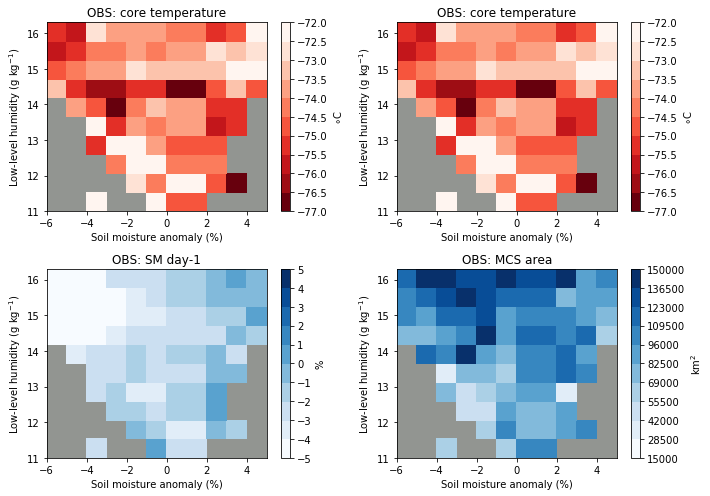

In [940]:
hist2d_quatro(data_list, valid=True)

In [872]:
wet.keys()

Index(['id', 'year', 'month', 'day', 'hour', 'lon', 'lat', 'xloc', 'yloc',
       'area', 'csize', 't', 'storm_id', 'topo', 'SMmean0', 'SMdry0', 'SMwet0',
       'SMmean-1', 'SMdry-1', 'SMwet-1', 'LSTAmean', 'LSTAslotfrac', 'dtime',
       'ERAqmean'],
      dtype='object')

In [649]:
print('Number of wet cases:', wet.shape[0])

Number of wet cases: 283


### The dry case shows a shift in the core temperature distribution by -2K

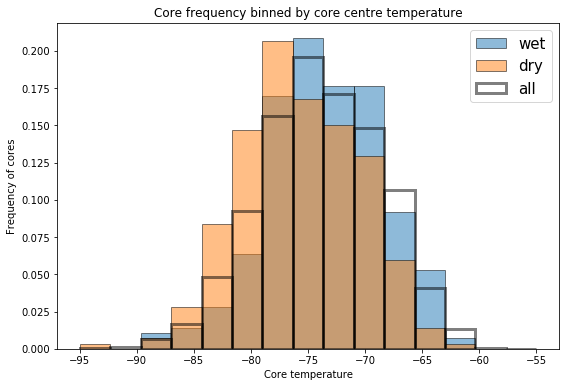

In [136]:
f= plt.figure(figsize=(9,6))
ax = f.add_subplot(111)
u_plot.hist_freq(ax, wet.t, alpha=0.5, label='wet', edgecolor='k', bins=15, range=(-95,-55))
u_plot.hist_freq(ax, dry.t, alpha=0.5, label='dry', edgecolor='k', bins=15, range=(-95,-55))
u_plot.hist_freq(ax, msgopen.t, alpha=0.5, label='all', edgecolor='k', linewidth=3, bins=15, range=(-95,-55), facecolor='None')
plt.legend(fontsize=15)
plt.ylabel('Frequency of cores')
plt.xlabel('Core temperature')
plt.title('Core frequency binned by core centre temperature')
plt.savefig('/home/ck/DIR/cornkle/figs/LSTA/corrected_LSTA/new/coreT_new.png')

In [137]:
np.percentile(msgopen.t, 10)

-81.0

In [138]:
np.sum(wet.t<-81.389)/wet.t.size

0.053003533568904596

In [139]:
np.sum(dry.t<-81.389)/wet.t.size

0.14840989399293286

In [140]:
print('Core mean temperature DRY: ', np.mean(np.mean(dry.t)))
print('Core mean temperature WET: ', np.mean(np.mean(wet.t)))

Core mean temperature DRY:  -75.83493019816234
Core mean temperature WET:  -73.58869795203995


In [141]:
print('Core mean temperature DRY: ', np.mean(np.percentile(dry.t,10)))
print('Core mean temperature WET: ', np.mean(np.percentile(wet.t,10)))

Core mean temperature DRY:  -82.36553424842197
Core mean temperature WET:  -79.86003434344788


### We get very few wet cases in June 

Text(0.5,1,'Core frequency binned by month')

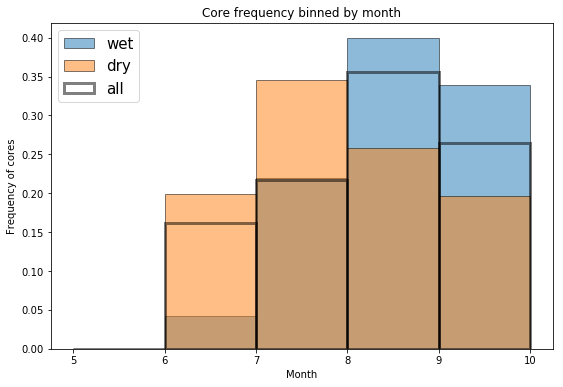

In [142]:
f= plt.figure(figsize=(9,6))
ax = f.add_subplot(111)
u_plot.hist_freq(ax, wet.month, alpha=0.5, label='wet', edgecolor='k', bins=5, range=(5,10))
u_plot.hist_freq(ax, dry.month, alpha=0.5, label='dry', edgecolor='k', bins=5, range=(5,10))
u_plot.hist_freq(ax, msgopen.month, alpha=0.5, label='all', edgecolor='k', linewidth=3, bins=5, range=(5,10), facecolor='None')
plt.legend(fontsize=15)
plt.ylabel('Frequency of cores')
plt.xlabel('Month')
plt.title('Core frequency binned by month')

### The dry cases tend to occur further south - as expected from main occurence during June/July
### The wet case doesn't show such a preference

Text(0.5,1,'Core frequency binned by latitude')

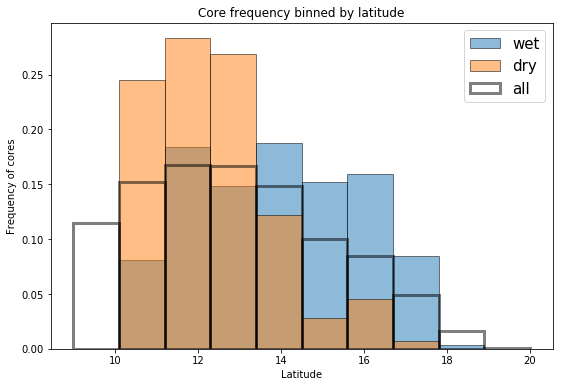

In [143]:
f= plt.figure(figsize=(9,6))
ax = f.add_subplot(111)
u_plot.hist_freq(ax, wet.lat, alpha=0.5, label='wet', edgecolor='k', bins=10, range=(9,20))
u_plot.hist_freq(ax, dry.lat, alpha=0.5, label='dry', edgecolor='k', bins=10, range=(9,20))
u_plot.hist_freq(ax, msgopen.lat, alpha=0.5, label='all', edgecolor='k', linewidth=3, bins=10, range=(9,20), facecolor='None')
plt.legend(fontsize=15)
plt.ylabel('Frequency of cores')
plt.xlabel('Latitude')
plt.title('Core frequency binned by latitude')

In [144]:
topo = xr.open_dataarray(cnst.network_data + 'data/ancils_python/lsta_corr_topo.nc')
topo = topo.sel(lat=slice(9,16))
h = topo.mean(dim='lat')

### Overall core frequency follows topography. Would have to look into dry-core case around 5W

Text(0.5,1,'Core frequency binned by longitude')

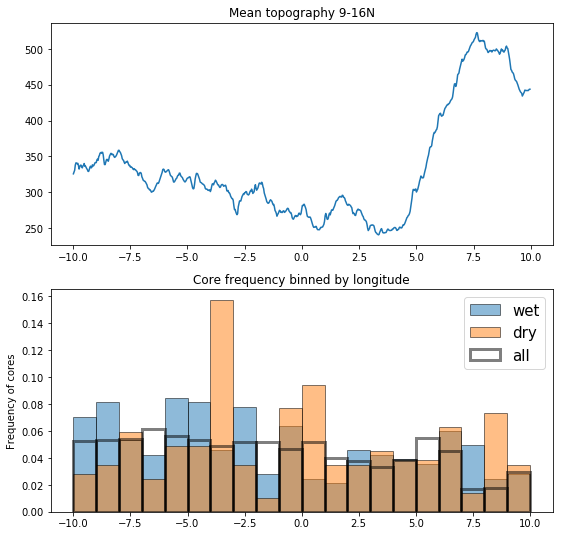

In [145]:
f= plt.figure(figsize=(9,9))

ax = f.add_subplot(211)
ax.plot(h.lon,h)
plt.title('Mean topography 9-16N')

ax = f.add_subplot(212)
u_plot.hist_freq(ax, wet.lon, alpha=0.5, label='wet', edgecolor='k', bins=20, range=(-10,10))
u_plot.hist_freq(ax, dry.lon, alpha=0.5, label='dry', edgecolor='k', bins=20, range=(-10,10))
u_plot.hist_freq(ax, msgopen.lon, alpha=0.5, label='all', edgecolor='k', linewidth=3,  bins=20, range=(-10,10), facecolor='None')
plt.legend(fontsize=15)
#ax.plot(h.lon, h)
plt.legend(fontsize=15)
plt.ylabel('Frequency of cores')
plt.title('Core frequency binned by longitude')

### Atmospheric conditions associated with the dry case favour shear and therefore organisation into bigger storms? 

Text(0.5,1,'Core frequency binned by storm area')

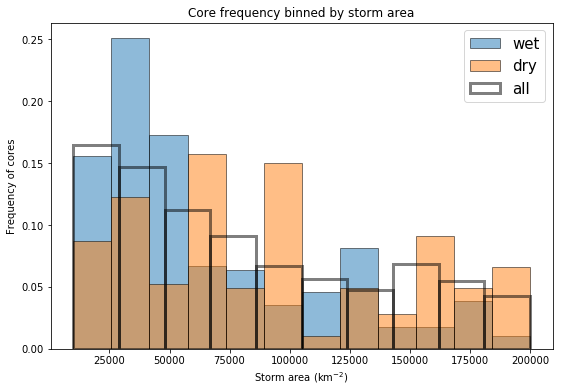

In [146]:
f= plt.figure(figsize=(9,6))
ax = f.add_subplot(111)
u_plot.hist_freq(ax, wet.area, alpha=0.5, label='wet', edgecolor='k', bins=12, range=(10000,200000))
u_plot.hist_freq(ax, dry.area, alpha=0.5, label='dry', edgecolor='k', bins=12, range=(10000,200000))
u_plot.hist_freq(ax, msgopen.area, alpha=0.5, label='all', edgecolor='k', linewidth=3, bins=10, range=(10000,200000), facecolor='None')

plt.legend(fontsize=15)
plt.ylabel('Frequency of cores')
plt.xlabel('Storm area (km$^{-2}$)')
plt.title('Core frequency binned by storm area')

In [94]:
np.mean(wet.area)

75118.12749003984

In [95]:
np.mean(dry.area)

118019.9806949807

In [96]:
(np.mean(dry.area) - np.mean(wet.area)) / np.mean(wet.area)

0.5711251682974838

In [ ]:
plt.scatter